In [1]:
a1 = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_emci_metab_hmdb_lilikoi.csv')
a2 = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_lmci_metab_hmdb_lilikoi.csv')
rownames(a1) = a1$PID
rownames(a2) = a2$PID
adni_meta2 = rbind(a1,a2[,colnames(a1)])

In [2]:
adni_meta = as.data.frame(adni_meta2)
adni_meta = adni_meta[,-c(1,2)]

In [4]:
adni_gene = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Data/ADNI_MRNA.csv',row.names=2)
adni_gene = adni_gene[,-c(1)]
dim(adni_gene)
adni_gene[1:5,1:3]

In [5]:
sum(rownames(adni_meta)%in%rownames(adni_gene))
adni_meta[1:2,1:2]
dim(adni_meta)

[1] 401

,HMDB00619,HMDB00518
,<dbl>,<dbl>
002_S_2043,-0.8792540,-0.1875521
002_S_2073,-0.7398908,-1.9193004


[1] 401 172

In [6]:
de_metab_emci = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Data/New_adj_DEmetab_EMCI.csv',row.names = 1)
de_metab_lmci = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Data/New_adj_DEmetab_LMCI.csv',row.names = 1)
de_metab = unique(c(rownames(de_metab_emci),rownames(de_metab_lmci)))
length(de_metab)

de_gene_emci = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Data/New_adj_limmaDE_EMCI.csv',row.names = 1)
de_gene_lmci = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Data/New_adj_limmaDE_LMCI.csv',row.names = 1)
de_gene = unique(c(rownames(de_gene_emci),rownames(de_gene_lmci)))
length(de_gene)


[1] 136

[1] 181

In [7]:
dim(de_metab_emci)
dim(de_metab_lmci)

dim(de_gene_emci)
dim(de_gene_lmci)

[1] 102   9

[1] 118   9

[1] 158   9

[1] 42  9

In [8]:
sum(rownames(adni_gene)==rownames(adni_meta))
dim(adni_gene)
dim(adni_meta)

adni_meta_de = adni_meta[,colnames(adni_meta)%in%de_metab]
adni_gene_de = adni_gene[,colnames(adni_gene)%in%de_gene]

dim(adni_meta_de)
dim(adni_gene_de)

[1] 401

[1]   401 20034

[1] 401 172

[1] 401 136

[1] 401 181

In [9]:
adni_multiomic = cbind(adni_meta_de,adni_gene_de)

In [10]:
#adni_meta2 = adni_meta[,colnames(EFIGA_metab)]
adni_meta2 = adni_multiomic
dim(adni_meta2)

[1] 401 317

In [11]:
label_adni = read.csv('/nfs/dcmb-lgarmire/boweil/ADNI_Tidy/Code/Figure56_Validation/Labels/ADNI_all.csv')[,c('X','subtype_big')]
label_adni[1:5,]

,X,subtype_big
,<chr>,<chr>
1,002_S_0729,LMCI2
2,002_S_1155,LMCI1
3,002_S_1268,LMCI1
4,002_S_2043,EMCI2
5,002_S_2073,EMCI2


In [20]:
# Packages
library(caret)
library(glmnet)   # used under the hood by caret's method="glmnet"
set.seed(123)

# --- Inputs you already have ---
# met: data.frame or matrix of metabolites; rows = sample IDs; cols = HMDB features
# lab: data.frame with columns X (sample ID) and subtype_big (factor with 4 levels)

# Example to match your objects:
# str(met); head(met[,1:3])
# str(lab); head(lab)

# 1) Align samples between data and labels
ids <- intersect(rownames(adni_meta2), label_adni$X)
met2 <- adni_meta2[ids, , drop = FALSE]
y    <- factor(label_adni$subtype_big[match(ids, label_adni$X)])
stopifnot(length(y) == nrow(met2))
dat  <- data.frame(y = y, met2, check.names = FALSE)

# 2) Train/test split (stratified)
idx_train <- createDataPartition(dat$y, p = 0.8, list = FALSE)
train_df  <- dat[idx_train, ]
test_df   <- dat[-idx_train, ]

# 3) Resampling setup
ctrl <- trainControl(
  method = "repeatedcv",
  number = 5,
  repeats = 3,
  classProbs = TRUE,
  summaryFunction = multiClassSummary,  # gives Accuracy, Kappa, logLoss, etc.
  savePredictions = "final",
  sampling = NULL                       # set to "up", "down", or "smote" if classes imbalanced
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

322 samples
317 predictors
  4 classes: 'EMCI1', 'EMCI2', 'LMCI1', 'LMCI2' 

Pre-processing: median imputation (317), centered (317), scaled (317) 
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 258, 256, 259, 258, 257, 258, ... 
Resampling results across tuning parameters:

  alpha  lambda        logLoss    AUC        prAUC       Accuracy   Kappa      
  0.0    0.0001000000  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0001373824  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0001887392  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0002592944  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0003562248  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0004893901  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0006723358  0.8337247  0.8879357  0.69848271  0.6955284  0.592237480
  0.0    0.0009236709  0.8337247  0.88793

,EMCI1,EMCI2,LMCI1,LMCI2
,<dbl>,<dbl>,<dbl>,<dbl>
HMDB00651,0.000000,0.00000,0.000000,17.168960
HMDB06469,69.090237,85.05306,64.711516,89.431777
HMDB02250,0.000000,0.00000,0.000000,0.000000
HMDB02014,0.000000,0.00000,9.084881,0.000000
HMDB13330,0.000000,0.00000,0.000000,0.000000
HMDB13332,0.000000,27.92620,0.000000,37.267720
HMDB00222,66.815120,0.00000,0.000000,0.000000
HMDB13336,0.000000,0.00000,11.485842,0.000000
HMDB13207,0.000000,0.00000,0.000000,0.000000


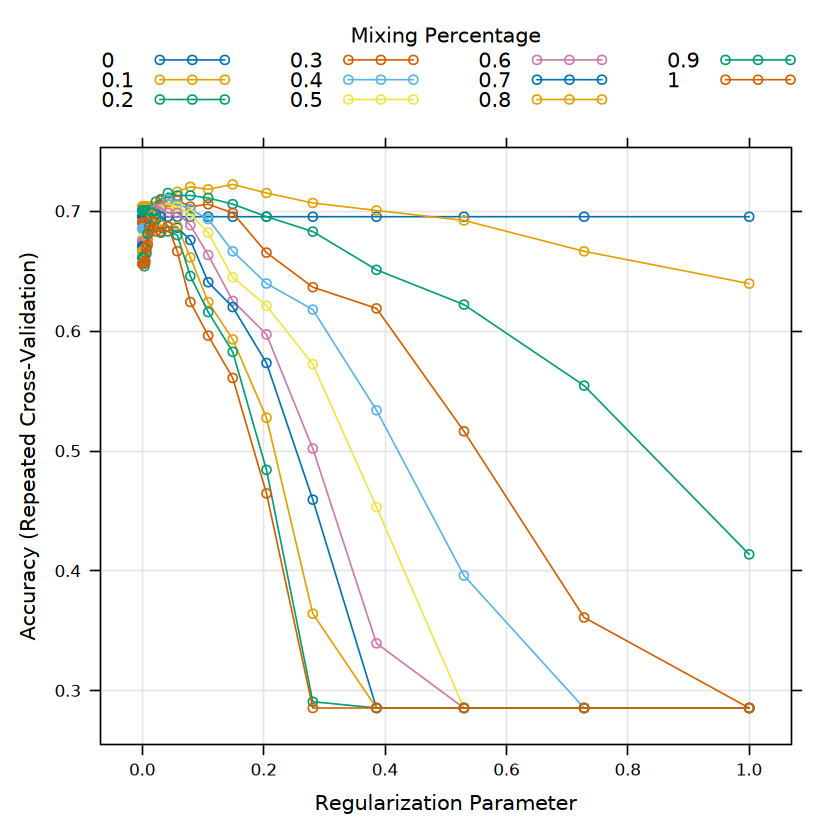

In [21]:
# 4) Preprocessing: NZV removal, median impute, center/scale
#    (Standardization is recommended for glmnet; remove preProcess for xgboost later)
preproc <- c("nzv", "medianImpute", "center", "scale")

# 5) Model 1: multinomial elastic-net (glmnet)
#    caret picks family="multinomial" automatically for multi-class factors, but we set explicitly.
glmnet_grid <- expand.grid(
  alpha = seq(0, 1, by = 0.1),            # ridge (0) -> lasso (1)
  lambda = 10^seq(0, -4, length.out = 30) # wide lambda path
)

fit_glmnet <- train(
  y ~ .,
  data = train_df,
  method = "glmnet",
  metric = "Accuracy",
  trControl = ctrl,
  preProcess = preproc,
  tuneGrid = glmnet_grid,
  family = "multinomial"
)

fit_glmnet
plot(fit_glmnet)            # see best alpha/lambda
varImp(fit_glmnet)$importance[1:25, , drop = FALSE]  # top features per class

In [22]:
# 6) Evaluate on held-out test set
pred_glmnet <- predict(fit_glmnet, newdata = test_df)
conf_glmnet <- confusionMatrix(pred_glmnet, test_df$y)
conf_glmnet

Confusion Matrix and Statistics

          Reference
Prediction EMCI1 EMCI2 LMCI1 LMCI2
     EMCI1    14     3     1     6
     EMCI2     1    11     0     7
     LMCI1     1     0    16     0
     LMCI2     5     4     0    10

Overall Statistics
                                        
               Accuracy : 0.6456        
                 95% CI : (0.5299, 0.75)
    No Information Rate : 0.2911        
    P-Value [Acc > NIR] : 7.387e-11     
                                        
                  Kappa : 0.5262        
                                        
 Mcnemar's Test P-Value : NA            

Statistics by Class:

                     Class: EMCI1 Class: EMCI2 Class: LMCI1 Class: LMCI2
Sensitivity                0.6667       0.6111       0.9412       0.4348
Specificity                0.8276       0.8689       0.9839       0.8393
Pos Pred Value             0.5833       0.5789       0.9412       0.5263
Neg Pred Value             0.8727       0.8833       0.9839       0.

In [12]:
saveRDS(fit_glmnet,'adni_classifier_fit_glmnet_multiomics_RERUN.rds')
#saveRDS(fit_glmnet,'adni_classifier_fit_glmnet_multiomics.rds')
#saveRDS(fit_xgb,'adni_classifier_fit_xgb_common54.rds')

In [14]:
fit_glmnet = readRDS('adni_classifier_fit_glmnet_multiomics.rds')

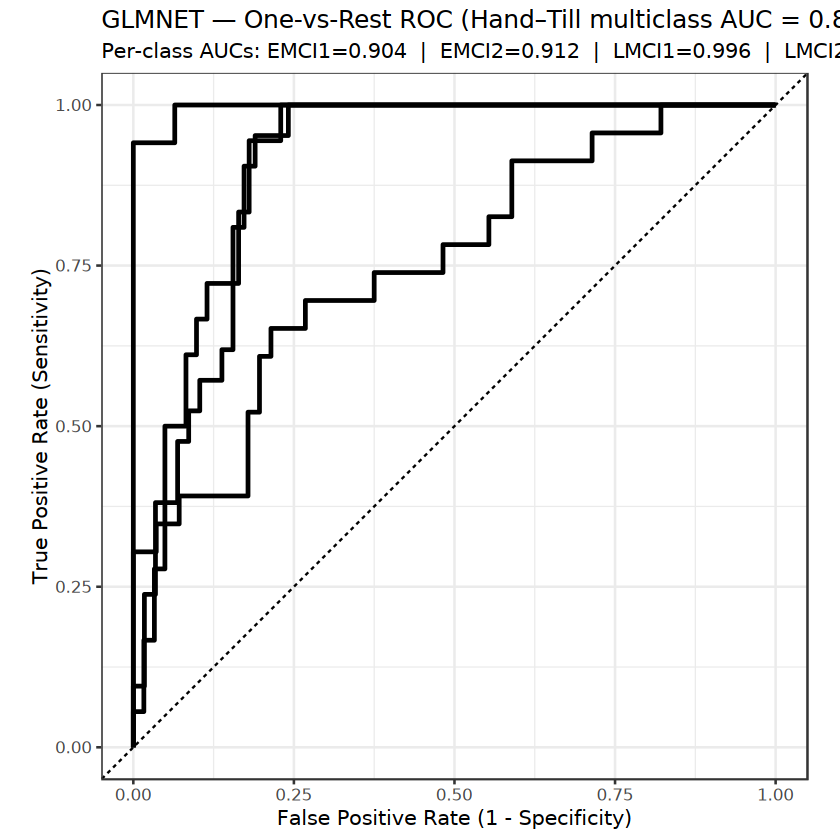

In [23]:
# Assumes you already have:
# - test_df with test_df$y as the true factor labels (4 levels)
# - fit_glmnet and fit_xgb trained as in the previous message

library(pROC)
library(ggplot2)
library(dplyr)
library(purrr)
library(tidyr)
set.seed(123)

# ---------- Helper: build per-class ROC data ----------
roc_one_vs_rest <- function(y_true, prob_df) {
  y_true <- factor(y_true)                 # ensure factor
  cls <- levels(y_true)
  # one-vs-rest ROC per class
  rocs <- map(cls, function(cn) {
    pos <- y_true == cn
    neg <- !pos
    if (sum(pos) == 0L || sum(neg) == 0L) return(NULL)  # skip if class missing
    r <- roc(response = pos, predictor = prob_df[[cn]], quiet = TRUE, direction = "<")
    tibble(
      class = cn,
      fpr = 1 - r$specificities,
      tpr = r$sensitivities,
      auc = as.numeric(auc(r))
    )
  })
  bind_rows(rocs)
}

# ---------- Helper: macro (Hand–Till) multiclass AUC ----------
multi_auc <- function(y_true, prob_df) {
  as.numeric(multiclass.roc(response = y_true, predictor = as.matrix(prob_df))$auc)
}

# ---------- Get probabilities on test set ----------
probs_glmnet <- predict(fit_glmnet, newdata = test_df, type = "prob")

# Ensure columns follow the same class order as the factor
lvl <- levels(test_df$y)
probs_glmnet <- probs_glmnet[, lvl, drop = FALSE]

# ---------- Build ROC data ----------
roc_glmnet <- roc_one_vs_rest(test_df$y, probs_glmnet)

auc_glmnet_macro <- multi_auc(test_df$y, probs_glmnet)

# ---------- Plotting function ----------
plot_ovr_roc <- function(roc_df, title_txt, macro_auc) {
  ggplot(roc_df, aes(x = fpr, y = tpr, group = class)) +
    geom_path(linewidth = 1) +
    geom_abline(slope = 1, intercept = 0, linetype = 2) +
    coord_equal() +
    labs(
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)",
      title = sprintf("%s — One-vs-Rest ROC (Hand–Till multiclass AUC = %.3f)", title_txt, macro_auc),
      subtitle = paste0(
        "Per-class AUCs: ",
        roc_df %>% group_by(class) %>% summarise(AUC = unique(round(auc, 3))) %>%
          mutate(txt = paste0(class, "=", AUC)) %>% pull(txt) %>% paste(collapse = "  |  ")
      )
    ) +
    theme_bw(base_size = 12)
}

# ---------- Draw plots ----------
p_glmnet <- plot_ovr_roc(roc_glmnet, "GLMNET", auc_glmnet_macro)
print(p_glmnet)

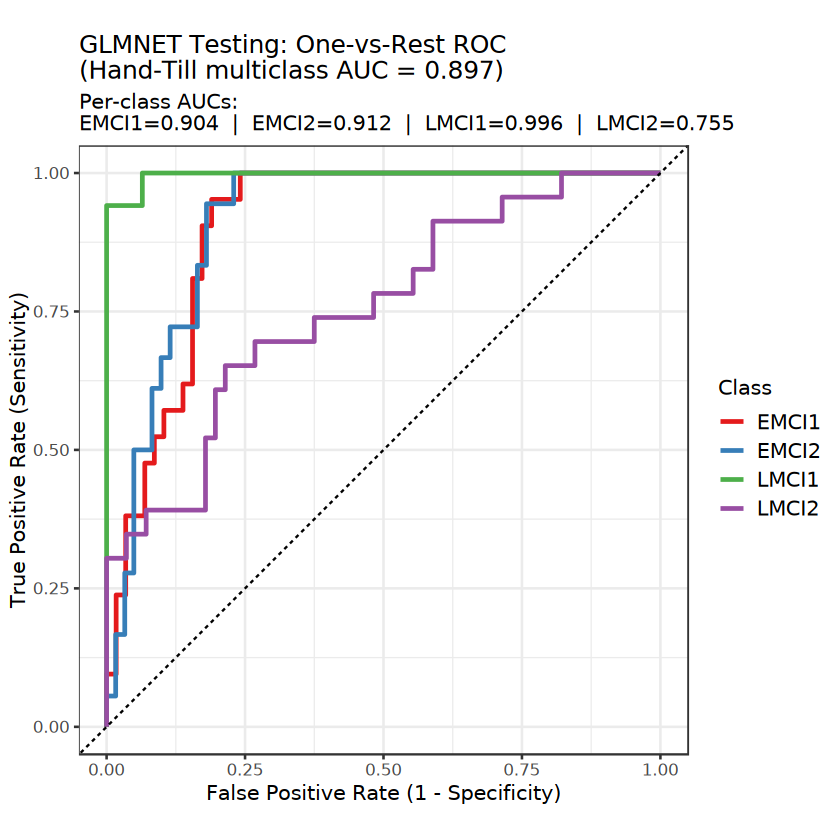

In [39]:
plot_ovr_roc <- function(roc_df, title_txt, macro_auc) {
  ggplot(roc_df, aes(x = fpr, y = tpr, color = class)) +   # ← add color aesthetic
    geom_path(linewidth = 1) +
    geom_abline(slope = 1, intercept = 0, linetype = 2) +
    coord_equal() +
    scale_color_brewer(palette = "Set1") +                 # or use "Dark2", "Set2", "Paired", etc.
    labs(
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)",
      color = "Class",
      title = sprintf("%s Testing: One-vs-Rest ROC \n(Hand-Till multiclass AUC = %.3f)",
                      title_txt, macro_auc),
      subtitle = paste0(
        "Per-class AUCs:\n",
        roc_df %>%
          group_by(class) %>%
          summarise(AUC = unique(round(auc, 3))) %>%
          mutate(txt = paste0(class, "=", AUC)) %>%
          pull(txt) %>%
          paste(collapse = "  |  ")
      )
    ) +
    theme_bw(base_size = 12) +
    theme(legend.position = "right",
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 12))
}
p_glmnet <- plot_ovr_roc(roc_glmnet, "GLMNET", auc_glmnet_macro)
print(p_glmnet)

In [16]:
pdf('classifier_adni_testing_glmnet_xgboost_multiclass_multiomics.pdf',width=8,height =8)
print(p_glmnet)
dev.off()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GLMNET — One-vs-Rest ROC (Hand–Till multiclass AUC = 0.864)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GLMNET — One-vs-Rest ROC (Hand–Till multiclass AUC = 0.864)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GLMNET — One-vs-Rest ROC (Hand–Till multiclass AUC = 0.864)' in 'mbcsToSbcs': dot substituted for <94>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GLMNET — One-vs-Rest ROC (Hand–Till multiclass AUC = 0.864)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GLMNET — One-vs-Rest ROC (Hand–Till multiclass AUC = 0

png 
  2

In [40]:
png('classifier_adni_testing_glmnet_xgboost_multiclass_multiomics2.png',width=6,height =6,unit='in',res=600)
print(p_glmnet)
dev.off()

png 
  2

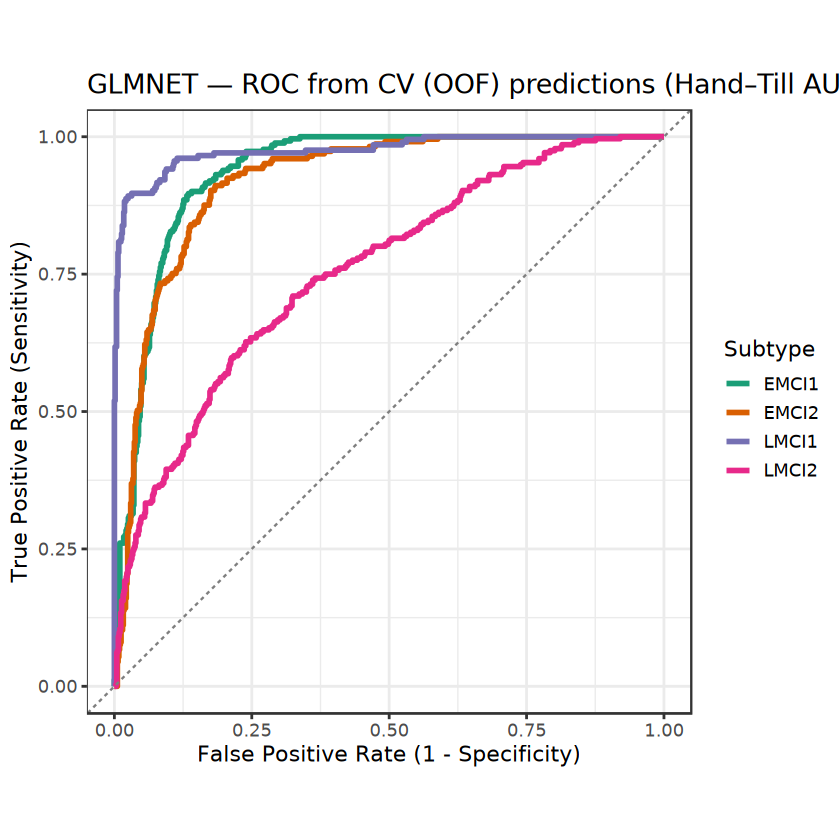

In [30]:
# Requirements (as before during training)
# trainControl(..., classProbs = TRUE, summaryFunction = multiClassSummary,
#              savePredictions = "final")

library(pROC)
library(ggplot2)
library(dplyr)
library(purrr)
set.seed(123)

# ---- Helpers (same logic as test-set version) ----
roc_one_vs_rest <- function(y_true, prob_df) {
  y_true <- factor(y_true)
  cls <- levels(y_true)
  rocs <- map(cls, function(cn) {
    pos <- y_true == cn
    neg <- !pos
    if (sum(pos) == 0L || sum(neg) == 0L) return(NULL)
    r <- roc(response = pos, predictor = prob_df[[cn]], quiet = TRUE, direction = "<")
    tibble(class = cn,
           fpr = 1 - r$specificities,
           tpr = r$sensitivities,
           auc = as.numeric(auc(r)))
  })
  bind_rows(rocs)
}

multi_auc <- function(y_true, prob_df) {
  as.numeric(multiclass.roc(response = y_true, predictor = as.matrix(prob_df))$auc)
}

plot_ovr_roc_colored <- function(roc_df, title_txt, macro_auc) {
  ggplot(roc_df, aes(x = fpr, y = tpr, color = class)) +
    geom_path(linewidth = 1.2) +
    geom_abline(slope = 1, intercept = 0, linetype = 2, color = "gray50") +
    scale_color_brewer(palette = "Dark2") +
    coord_equal() +
    labs(
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)",
      color = "Subtype",
      title = sprintf("%s — ROC from CV (OOF) predictions (Hand–Till AUC = %.3f)", title_txt, macro_auc)
    ) +
    theme_bw(base_size = 13)
}

# ---- Grab OUT-OF-FOLD probs from caret fits ----
# Keeps only rows corresponding to the best tuned parameters to avoid mixing grids.
get_oof <- function(fit, y_levels) {
  pr <- fit$pred
  for (nm in names(fit$bestTune)) {
    pr <- pr[pr[[nm]] == fit$bestTune[[nm]], ]
  }
  pr$obs <- factor(pr$obs, levels = y_levels)
  probs <- pr[, y_levels, drop = FALSE]   # columns named exactly by levels
  list(obs = pr$obs, probs = probs)
}

# levels from your training data
lvl <- levels(train_df$y)

oof_glmnet <- get_oof(fit_glmnet, lvl)

# ---- Build ROC data from OOF predictions (training CV) ----
roc_glmnet_cv <- roc_one_vs_rest(oof_glmnet$obs, oof_glmnet$probs)

auc_glmnet_cv <- multi_auc(oof_glmnet$obs, oof_glmnet$probs)

# ---- Draw colored training (CV) ROC plots ----
p_glmnet_cv <- plot_ovr_roc_colored(roc_glmnet_cv, "GLMNET", auc_glmnet_cv)

print(p_glmnet_cv)


In [31]:

# ---------- Get probabilities on test set ----------
probs_glmnet2 <- predict(fit_glmnet, newdata = train_df, type = "prob")

# Ensure columns follow the same class order as the factor
lvl <- levels(train_df$y)
probs_glmnet2 <- probs_glmnet2[, lvl, drop = FALSE]

# ---------- Build ROC data ----------
roc_glmnet2 <- roc_one_vs_rest(train_df$y, probs_glmnet2)

auc_glmnet2_macro <- multi_auc(train_df$y, probs_glmnet2)

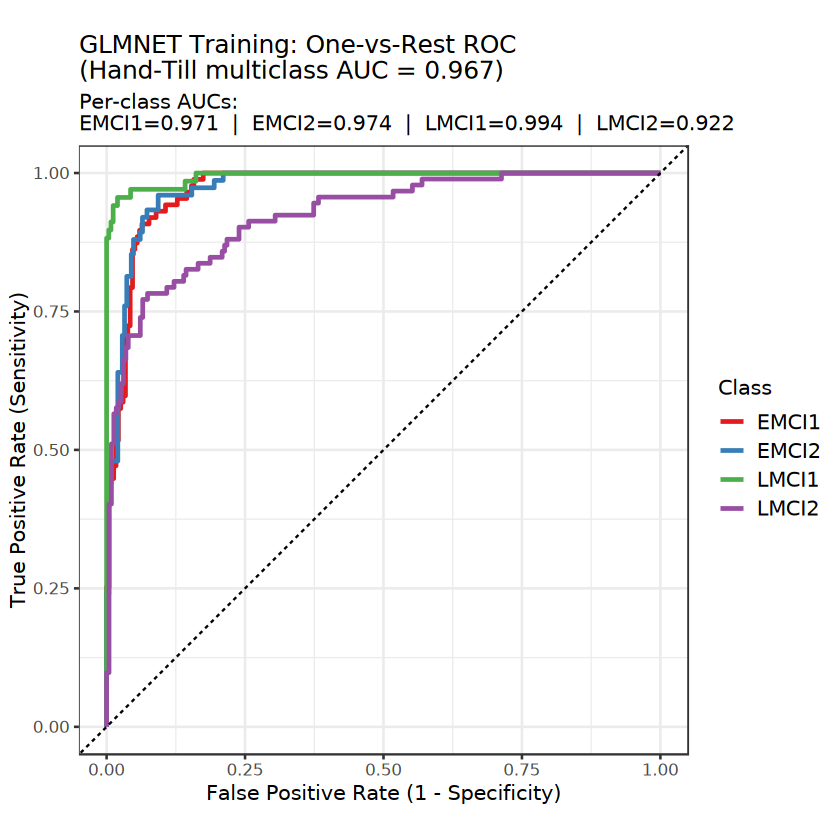

In [41]:


plot_ovr_roc <- function(roc_df, title_txt, macro_auc) {
  ggplot(roc_df, aes(x = fpr, y = tpr, color = class)) +   # ← add color aesthetic
    geom_path(linewidth = 1) +
    geom_abline(slope = 1, intercept = 0, linetype = 2) +
    coord_equal() +
    scale_color_brewer(palette = "Set1") +                 # or use "Dark2", "Set2", "Paired", etc.
    labs(
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)",
      color = "Class",
      title = sprintf("%s Training: One-vs-Rest ROC \n(Hand-Till multiclass AUC = %.3f)",
                      title_txt, macro_auc),
      subtitle = paste0(
        "Per-class AUCs: \n",
        roc_df %>%
          group_by(class) %>%
          summarise(AUC = unique(round(auc, 3))) %>%
          mutate(txt = paste0(class, "=", AUC)) %>%
          pull(txt) %>%
          paste(collapse = "  |  ")
      )
    ) +
    theme_bw(base_size = 12) +
    theme(legend.position = "right",
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 12))
}
p_glmnet2_cv <- plot_ovr_roc(roc_glmnet2, "GLMNET", auc_glmnet2_macro)
print(p_glmnet2_cv)

In [42]:
png('classifier_adni_training_glmnet_xgboost_multiclass_multiomics2.png',height =6,width = 6,unit='in',res=600)
print(p_glmnet2_cv)
dev.off()

png 
  2

In [52]:
EFIGA_metab_all = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Data/EFIGA_smalllabel.csv',row.names = 1)
EFIGA_metab[1:3,]
dim(EFIGA_metab)

,HMDB0000062,HMDB0000651,HMDB0006469,HMDB0002250,HMDB13330,HMDB13331,HMDB13332,HMDB0000222,HMDB00848,HMDB0000201,⋯,HMDB0000159,HMDB0000162,HMDB0062263,HMDB0000167,HMDB0000929,HMDB0002141,HMDB0000562,HMDB0000870,HMDB0000684,HMDB00725
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11227,0.82829591,2.261200,0.10374382,0.9869379,0.5513237,0.4025420,0.4217412,0.06415676,0.12871467,1.05178303,⋯,0.4689118,-0.3029499,-1.1850982,0.997543628,0.9453178,0.82829591,2.4644034,-0.052581159,1.402716,1.4027156
11245,-0.09544307,1.999741,0.03463932,1.4304307,0.8640256,1.1010787,0.8819317,-0.13921167,0.06415676,0.21081236,⋯,-0.4196463,0.4192514,-0.8010597,0.805443123,-1.4411009,0.61872600,-0.5297853,0.656711735,-1.804312,1.1806857
90159,-0.45544939,-1.232353,-1.25397973,-1.2205793,1.5752085,-0.3280522,-0.8351994,-1.18509822,-0.96342695,-0.09151265,⋯,-0.8443389,0.7900282,-0.1392117,0.008196061,-1.1157608,0.07006711,1.7638228,-0.003930137,1.261128,-0.6597572


[1] 717  54

In [53]:
EFIGA_metab = EFIGA_metab_all[,1:54]
EFIGA_label = EFIGA_metab_all[,c('labels_refined','ID')]

EFIGA_metab[1:3,1:3]
EFIGA_label[1:5,]

,HMDB0000062,HMDB0000651,HMDB0006469
,<dbl>,<dbl>,<dbl>
11227,0.82829591,2.261200,0.10374382
11245,-0.09544307,1.999741,0.03463932
90159,-0.45544939,-1.232353,-1.25397973


,labels_refined,ID
,<chr>,<int>
11227,LMCI2,11227
11245,LMCI1,11245
90159,EMCI1,90159
90271,EMCI1,90271
90272,EMCI2,90272


In [56]:
newdata = EFIGA_metab
newlabel = EFIGA_label

In [58]:
table(newlabel$labels_refined)


EMCI1 EMCI2 LMCI1 LMCI2 
  288   248    75   106 

In [62]:
library(dplyr)
library(pROC)

## 0) Make sure IDs are character rownames for newdata
# rownames(newdata) <- as.character(rownames(newdata))  # if needed

## 1) Predict on ALL newdata
pred_glmnet <- predict(fit_glmnet, newdata = align_to_model(newdata, fit_glmnet))
probs_glmnet <- predict(fit_glmnet, newdata = align_to_model(newdata, fit_glmnet), type = "prob")
pred_xgb <- predict(fit_xgb, newdata = align_to_model(newdata, fit_xgb))
probs_xgb <- predict(fit_xgb, newdata = align_to_model(newdata, fit_xgb), type = "prob")

pred_df <- data.frame(ID = rownames(newdata),
                      pred_glmnet = pred_glmnet,
                      pred_xgb    = pred_xgb,
                      check.names = FALSE)

## 2) Join labels and predictions on the ID overlap
eval_df <- newlabel %>%
  mutate(ID = as.character(ID),
         truth = labels_refined) %>%
  inner_join(pred_df, by = "ID")

cat("Counts in the overlap (this is what AUC uses):\n")
print(table(eval_df$truth))

## 3) Build truth factor with model’s training levels, then drop absent ones
train_lvls <- levels(fit_glmnet$trainingData$.outcome)
truth <- factor(eval_df$truth, levels = train_lvls)
truth_present <- droplevels(truth)
present_lvls <- levels(truth_present)

## 4) Align probability matrices to the overlap rows and present classes
probs_eval_glmnet <- probs_glmnet[eval_df$ID, present_lvls, drop = FALSE]
probs_eval_xgb    <- probs_xgb[eval_df$ID,    present_lvls, drop = FALSE]

## 5) Safe multiclass AUC (Hand–Till), only if ≥2 classes present in the overlap
safe_multiclass_auc <- function(truth_fac, probs_df) {
  lv <- levels(truth_fac)
  if (length(lv) < 2) return(NA_real_)
  as.numeric(multiclass.roc(response = truth_fac,
                            predictor = as.matrix(probs_df))$auc)
}

auc_glmnet_new <- safe_multiclass_auc(truth_present, probs_eval_glmnet)
#auc_xgb_new    <- safe_multiclass_auc(truth_present, probs_eval_xgb)
cat(sprintf("GLMNET Hand–Till AUC (overlap): %s\n",
            ifelse(is.na(auc_glmnet_new), "NA (not enough classes)", sprintf("%.3f", auc_glmnet_new))))
#cat(sprintf("XGBoost Hand–Till AUC (overlap): %s\n",
#            ifelse(is.na(auc_xgb_new), "NA (not enough classes)", sprintf("%.3f", auc_xgb_new))))

Counts in the overlap (this is what AUC uses):

EMCI1 EMCI2 LMCI1 LMCI2 
  288   248    75   106 
GLMNET Hand–Till AUC (overlap): 0.401


Counts in overlap used for metrics:

EMCI1 EMCI2 LMCI1 LMCI2 
  288   248    75   106 
   Accuracy       Kappa 
 0.15341702 -0.05655939 
GLMNET-ADNI multiclass AUC on EFIGA: 0.401


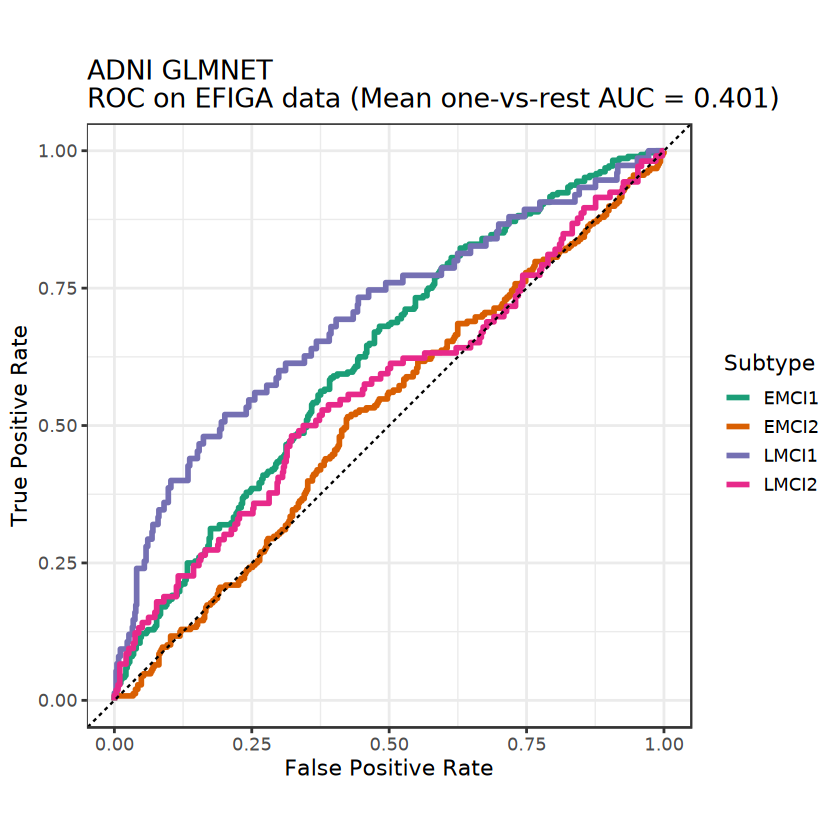

In [76]:
# --- helpers ---------------------------------------------------------------
`%||%` <- function(a, b) if (!is.null(a)) a else b

# 1) Align features to the training model
align_to_model <- function(df, fit) {
  feats <- (fit$finalModel$xNames %||% fit$xNames)
  if (is.null(feats)) stop("Couldn't find xNames in model; check saved fit.")
  miss <- setdiff(feats, colnames(df))
  if (length(miss)) df[, miss] <- NA_real_
  out <- df[, feats, drop = FALSE]
  out[] <- lapply(out, as.numeric)
  out
}

# 2) Predict labels + probs on newdata (and force prob columns to model level order)
predict_on_new <- function(fit, newdata_raw) {
  X <- align_to_model(newdata_raw, fit)
  preds <- predict(fit, newdata = X)
  probs <- predict(fit, newdata = X, type = "prob")
  lvl   <- levels(fit$trainingData$.outcome)
  probs <- probs[, lvl, drop = FALSE]  # align columns to training levels
  list(pred = preds, prob = probs)
}

# 3) Safe Hand–Till multiclass AUC (drops absent classes in the overlap)
safe_multiclass_auc <- function(truth, probs) {
  truth2 <- droplevels(truth)
  present <- levels(truth2)
  if (length(present) < 2) return(NA_real_)
  probs2 <- probs[, present, drop = FALSE]
  as.numeric(pROC::multiclass.roc(response = truth2,
                                  predictor = as.matrix(probs2))$auc)
}

# 4) One-vs-rest ROC (auto direction) with colored curves
roc_one_vs_rest <- function(y_true, prob_df) {
  y_true <- droplevels(factor(y_true))
  cls <- levels(y_true)
  dplyr::bind_rows(lapply(cls, function(cn) {
    pos <- y_true == cn
    neg <- !pos
    if (sum(pos) == 0L || sum(neg) == 0L) return(NULL)
    r <- pROC::roc(response = pos, predictor = prob_df[[cn]], quiet = TRUE) # <-- auto direction
    tibble::tibble(
      class = cn,
      fpr = 1 - r$specificities,
      tpr = r$sensitivities,
      auc = as.numeric(pROC::auc(r))
    )
  }))
}

plot_ovr <- function(roc_df, title_txt, macro_auc) {
  ggplot2::ggplot(roc_df, ggplot2::aes(fpr, tpr, color = class)) +
    ggplot2::geom_path(linewidth = 1.2) +
    ggplot2::geom_abline(slope = 1, intercept = 0, linetype = 2) +
    ggplot2::coord_equal() +
    ggplot2::scale_color_brewer(palette = "Dark2") +
    ggplot2::labs(
      title = sprintf("ADNI %s \nROC on EFIGA data (Mean one-vs-rest AUC = %s)",
                      title_txt,
                      ifelse(is.na(macro_auc), "NA", sprintf("%.3f", macro_auc))),
      x = "False Positive Rate", y = "True Positive Rate", color = "Subtype"
    ) +
    ggplot2::theme_bw(13)
}

# --- apply to your objects --------------------------------------------------
# Assumes: fit_glmnet, fit_xgb, newdata (rownames are IDs), newlabel (ID, labels_refined)

# Predict on all newdata
out_glmnet <- predict_on_new(fit_glmnet, newdata)
out_xgb    <- predict_on_new(fit_xgb,    newdata)

pred_df <- data.frame(
  ID = rownames(newdata),
  pred_glmnet = out_glmnet$pred,
  pred_xgb    = out_xgb$pred,
  check.names = FALSE
)

# Join with available labels (overlap only)
eval_df <- newlabel %>%
  dplyr::mutate(ID = as.character(ID),
                truth = factor(labels_refined,
                               levels = levels(fit_glmnet$trainingData$.outcome))) %>%
  dplyr::inner_join(pred_df, by = "ID")

# Print overlap counts (this is the set used for metrics)
cat("Counts in overlap used for metrics:\n"); print(table(droplevels(eval_df$truth)))

# Accuracy/Kappa on overlap
acc_glmnet <- caret::confusionMatrix(eval_df$pred_glmnet, eval_df$truth)
#acc_xgb    <- caret::confusionMatrix(eval_df$pred_xgb,    eval_df$truth)
print(acc_glmnet$overall[c("Accuracy","Kappa")])
#print(acc_xgb$overall[c("Accuracy","Kappa")])

# Probabilities restricted to overlap rows, columns aligned to training levels
probs_eval_glmnet <- out_glmnet$prob[eval_df$ID, , drop = FALSE]
#probs_eval_xgb    <- out_xgb$prob[eval_df$ID,    , drop = FALSE]

# Safe Hand–Till AUC (drops absent classes in the overlap automatically)
auc_glmnet_new <- safe_multiclass_auc(eval_df$truth, probs_eval_glmnet)
#auc_xgb_new    <- safe_multiclass_auc(eval_df$truth, probs_eval_xgb)

cat(sprintf("GLMNET-ADNI multiclass AUC on EFIGA: %s\n",
            ifelse(is.na(auc_glmnet_new), "NA", sprintf("%.3f", auc_glmnet_new))))
#cat(sprintf("XGBoost multiclass AUC on new cohort: %s\n",
#            ifelse(is.na(auc_xgb_new), "NA", sprintf("%.3f", auc_xgb_new))))

# Colored OVR ROC (on overlap)
roc_glmnet_new <- roc_one_vs_rest(eval_df$truth, probs_eval_glmnet)
#roc_xgb_new    <- roc_one_vs_rest(eval_df$truth, probs_eval_xgb)

p1 <- plot_ovr(roc_glmnet_new, "GLMNET", auc_glmnet_new)
#p2 <- plot_ovr(roc_xgb_new,    "XGBoost", auc_xgb_new)
print(p1)
#print(p2)


  class       AUC n_pos
1 EMCI1 0.6250567   288
2 EMCI2 0.5188717   248
3 LMCI1 0.6946625    75
4 LMCI2 0.5642004   106


png 
  2

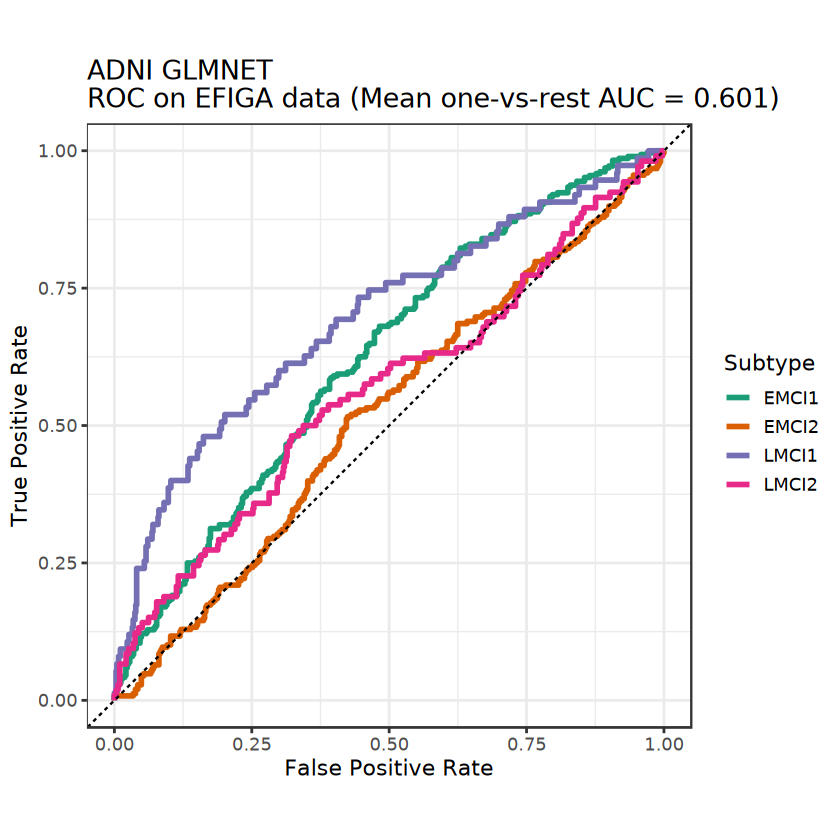

In [78]:
# ---- Compute per-class AUCs using only GLMNET ----
per_class_auc_glmnet <- function(truth, probs) {
  truth <- droplevels(truth)
  cls   <- levels(truth)
  probs <- probs[, cls, drop = FALSE]

  dplyr::bind_rows(lapply(cls, function(cn) {
    pos <- truth == cn
    neg <- !pos
    if (sum(pos) == 0L || sum(neg) == 0L)
      return(data.frame(class = cn, AUC = NA_real_, n_pos = sum(pos)))
    r <- pROC::roc(response = pos, predictor = probs[[cn]], quiet = TRUE)
    data.frame(class = cn, AUC = as.numeric(pROC::auc(r)), n_pos = sum(pos))
  })) %>% arrange(class)
}

# Compute per-class AUCs
per_cls_glmnet <- per_class_auc_glmnet(eval_df$truth, probs_eval_glmnet)
print(per_cls_glmnet)

# Use the macro (mean) AUC for your plot title
auc_glmnet_macro <- mean(per_cls_glmnet$AUC, na.rm = TRUE)

# ---- Plot colored ROC curves (using mean per-class AUC in title) ----
p1 <- plot_ovr(roc_glmnet_new, "GLMNET", auc_glmnet_macro)
print(p1)

pdf('classifier_EFIGA_validation_glmnet_multiclass_common54.pdf',width=8,height =8)
print(p1)
dev.off()

In [74]:
library(pROC)
library(dplyr)

# Inputs assumed from your pipeline:
# - eval_df$truth  (factor of true labels on the overlap)
# - probs_eval_glmnet (data.frame of class probabilities for those IDs)

per_class_auc_glmnet <- function(truth, probs) {
  truth  <- droplevels(truth)
  cls    <- levels(truth)
  probs  <- probs[, cls, drop = FALSE]  # keep columns for present classes only

  auc_rows <- lapply(cls, function(cn) {
    pos <- truth == cn
    neg <- !pos
    if (sum(pos) == 0L || sum(neg) == 0L)
      return(data.frame(class = cn, AUC = NA_real_, n = sum(pos)))
    r <- roc(response = pos, predictor = probs[[cn]], quiet = TRUE)  # auto direction
    data.frame(class = cn, AUC = as.numeric(auc(r)), n = sum(pos))
  })
  bind_rows(auc_rows) %>% arrange(class)
}

per_cls_glmnet <- per_class_auc_glmnet(eval_df$truth, probs_eval_glmnet)
print(per_cls_glmnet)

# Optional: macro and prevalence-weighted AUCs (glmnet only)
macro_glmnet <- mean(per_cls_glmnet$AUC, na.rm = TRUE)
w_glmnet     <- per_cls_glmnet$n / sum(per_cls_glmnet$n)
weighted_glmnet <- sum(per_cls_glmnet$AUC * w_glmnet, na.rm = TRUE)

cat(sprintf("GLMNET macro AUC = %.3f; prevalence-weighted AUC = %.3f\n",
            macro_glmnet, weighted_glmnet))

  class       AUC   n
1 EMCI1 0.6250567 288
2 EMCI2 0.5188717 248
3 LMCI1 0.6946625  75
4 LMCI2 0.5642004 106
GLMNET macro AUC = 0.601; prevalence-weighted AUC = 0.587
